In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import gaussian_kde
from scipy.integrate import simps

In [2]:
class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = np.full(num_particles, mass)  # Mass for each particle
        self.dt = dt
        self.total_time = total_time

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.time_steps = int(total_time / dt)  # Total number of time steps
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # Store trajectory

    def forces(self, positions):
        # Calculate the spring forces
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                # Calculate the spring force based on Hooke's law
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities from the state vector y
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        # Calculate forces
        F = self.forces(positions)

        # Add damping force (assumed uniform damping coefficient)
        damping_coefficient = 0.2  # Adjust this value as needed
        damping_force = -damping_coefficient * velocities

        # Equations of motion: d(position)/dt = velocity, d(velocity)/dt = (force + damping) / mass
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = ((F + damping_force) / self.mass[:, None]).flatten()  # d(velocity)/dt = (force + damping) / mass

        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)

        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)

        # Extract positions from the solution
        positions = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        self.trajectory = positions  # Store the trajectory
        return t, positions

    def generate_transition_matrix(self):
        # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))

        # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])
                    # Track cumulative displacements for self and inter-particle transitions
                    cumulative_displacements[i, j] += displacement

        # Use cumulative displacement to adjust transition probabilities
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                    # The smaller the displacement, the higher the transition probability
                    if cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def sample_random_walk(self, transition_matrix, num_steps, initial_state=0):
        state = initial_state
        visited_states = [state]

        for _ in range(num_steps):
            state = np.random.choice(self.num_particles, p=transition_matrix[state])
            visited_states.append(state)

        return visited_states

    def plot_trajectories(self):
        # Plot the trajectories of particles as a function of time
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X Position', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y Position', linestyle='--')

        plt.title('Trajectories of Particles Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()
        
    def compute_kde(self, visited_states):
        # Compute the underlying probability distribution using KDE
        kde = gaussian_kde(visited_states)

        # Set x-axis range from -5.0 to a large number to simulate infinity
        X = np.linspace(-5.0, 100, 1000)  # X ranges from 0 to 100 as a proxy for infinity
        P_X = kde(X)
        
        # Normalize the area under the curve
        area_under_curve = simps(P_X, X)  # Integrating the probability distribution
        print(f"Area under the curve (should be ~1 for normalization): {area_under_curve}")

        return X, P_X

    def plot_probability_distribution(self, X, P_X):
        # Plot P(X) vs X
        plt.figure(figsize=(8, 6))
        plt.plot(X, P_X, label='Estimated Probability Distribution')
        plt.title('Probability Distribution Estimated from the Random Walk')
        plt.xlabel('State (X)')
        plt.ylabel('P(X)')
        plt.xlim(-5, 11)  # X-axis from 0 to a large value
        plt.grid(True)
        plt.legend()
        plt.show()

In [3]:
polymer = PolymerMotion(num_particles=5, spring_constants=np.random.rand(5))
polymer.simulate()
transition_matrix = polymer.generate_transition_matrix()

In [4]:
print(transition_matrix)

[[0.93290223 0.01853863 0.02315387 0.01030652 0.01509875]
 [0.01761023 0.9236739  0.02418657 0.01210017 0.02242913]
 [0.01777303 0.01972269 0.93540669 0.00887083 0.01822675]
 [0.01440288 0.01773194 0.01590806 0.93739675 0.01456038]
 [0.01380422 0.02162641 0.02138956 0.00958599 0.93359382]]


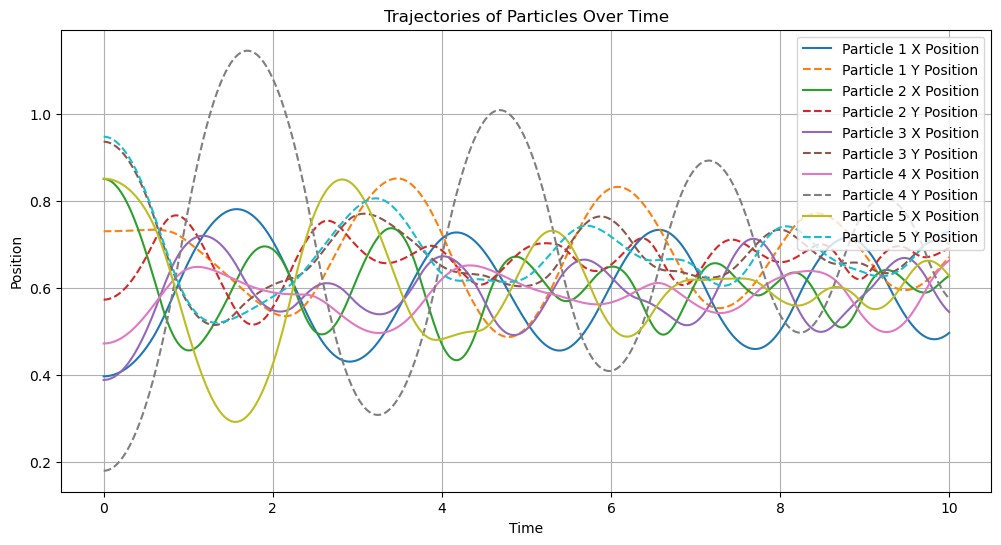

In [5]:
polymer.plot_trajectories()

/var/folders/cf/3rb10wvd7l5bcg3nnk3w22000000gn/T/ipykernel_78622/1457743669.py:130: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area_under_curve = simps(P_X, X)  # Integrating the probability distribution


Area under the curve (should be ~1 for normalization): 0.9999999999999998


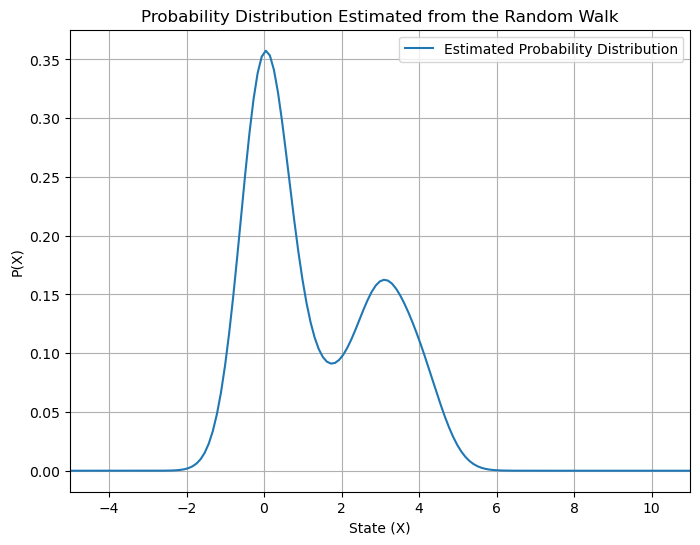

In [7]:
# Sample the random walk
num_steps = 100
initial_state = 0
visited_states = polymer.sample_random_walk(transition_matrix, num_steps, initial_state)


# Compute and plot probability distribution
X, P_X = polymer.compute_kde(visited_states)
polymer.plot_probability_distribution(X, P_X)

In [8]:
#Sample points from the distribution

def rejection_sampling(X, P_X, num_samples):
    # Normalize P_X to ensure it's a valid probability distribution
    P_X = P_X / np.sum(P_X)  # Ensure that P_X sums to 1

    # Determine the maximum value of the probability distribution for scaling
    max_P_X = np.max(P_X)

    # Initialize the list of accepted samples
    samples = []
    
    while len(samples) < num_samples:
        # Draw a random sample from X
        proposed_state = np.random.choice(X)

        # Draw a uniform random number to determine acceptance
        u = np.random.uniform(0, max_P_X)

        # Acceptance condition
        if u < P_X[np.argmin(np.abs(X - proposed_state))]:
            samples.append(proposed_state)

    return np.array(samples)

In [9]:
# Sampling usage
samples = rejection_sampling(X, P_X, num_samples=1000)

In [10]:
#Scale samples

import numpy as np

def scale_samples(samples, lower_limit, upper_limit):
    """
    Rescale the samples to lie within the given lower and upper limits.

    Parameters:
        samples (np.ndarray): The samples to be rescaled.
        lower_limit (float): The lower limit for scaling.
        upper_limit (float): The upper limit for scaling.

    Returns:
        np.ndarray: Rescaled samples.
    """
    # Find the current min and max of the samples
    min_sample = np.min(samples)
    max_sample = np.max(samples)

    # Rescale the samples to the new range [lower_limit, upper_limit]
    scaled_samples = lower_limit + (samples - min_sample) * (upper_limit - lower_limit) / (max_sample - min_sample)

    return scaled_samples

In [11]:
low=0
up=1
scaled_samples=scale_samples(samples, low, up)

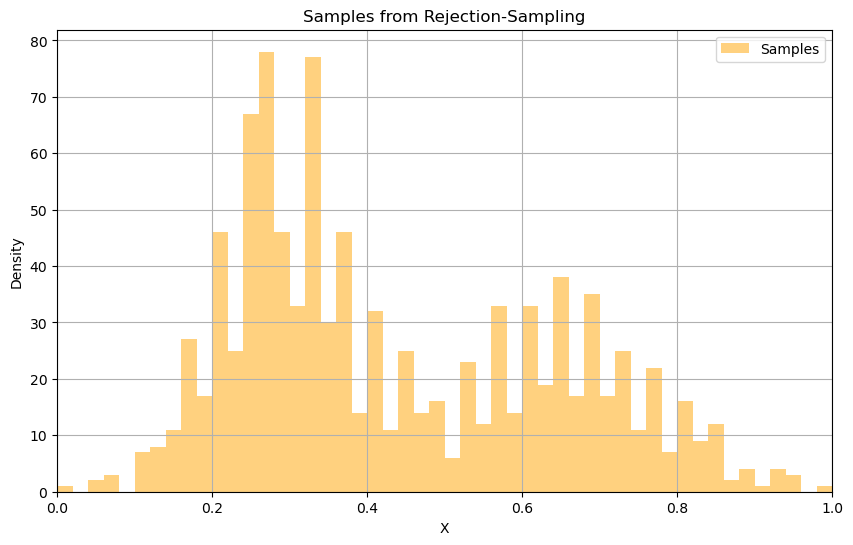

In [12]:
# Plotting samples
plt.figure(figsize=(10, 6))
plt.hist(scaled_samples, bins=50, density=False, label='Samples', color='orange', alpha=0.5)
plt.title('Samples from Rejection-Sampling')
plt.xlabel('X')
plt.xlim(low,up)
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Optimized lambda: 2.3002
Normalization factor (integral of PDF): 1.0000


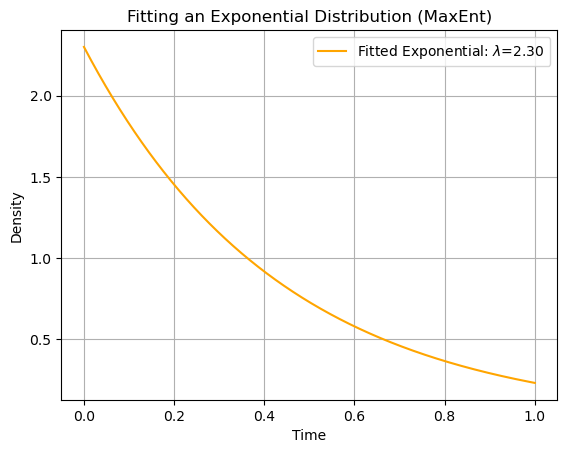

Final normalization check (should be close to 1): 1.0000


In [38]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Step 1: Assume `scaled_samples` contains your wait time samples
# For example purposes, let's generate some synthetic data
# (Replace this with your actual wait time samples)
np.random.seed(0)

# Step 2: Calculate the empirical mean of the samples
mean_empirical = np.mean(scaled_samples)

# Step 3: Define the negative entropy for the exponential distribution
def neg_entropy_exponential(params):
    lambda_param = params[0]  # Lambda (rate parameter)

    # Exponential distribution PDF
    def pdf_exponential(x):
        return lambda_param * np.exp(-lambda_param * x)

    # Calculate the probabilities of the empirical samples
    probabilities = pdf_exponential(scaled_samples)

    # Ensure non-zero probabilities to avoid log(0) issues
    probabilities[probabilities <= 0] = 1e-12

    # Calculate the entropy (negative log-likelihood)
    entropy = -np.mean(np.log(probabilities))

    return entropy

# Step 4: Optimize to find the best lambda
initial_guess = [1.0]  # Starting guess for lambda
result = minimize(neg_entropy_exponential, initial_guess)

# Step 5: Output the optimized parameter
if result.success:
    optimized_lambda = result.x[0]
    print(f"Optimized lambda: {optimized_lambda:.4f}")
else:
    print("Optimization failed.")

# Step 6: Create a fitted PDF with the optimized lambda
def fitted_pdf(x):
    return optimized_lambda * np.exp(-optimized_lambda * x)

# Step 7: Check normalization of the fitted PDF
normalization_factor, _ = quad(fitted_pdf, 0, np.inf)

# Normalization check
print(f"Normalization factor (integral of PDF): {normalization_factor:.4f}")

# Define normalized PDF
def normalized_fitted_pdf(x):
    return fitted_pdf(x) / normalization_factor

# Step 8: Generate x values for plotting
x_values = np.linspace(0, np.max(scaled_samples), 1000)
fitted_pdf_values = normalized_fitted_pdf(x_values)

# Plot the fitted PDF
plt.plot(x_values, fitted_pdf_values, label=f"Fitted Exponential: $\\lambda$={optimized_lambda:.2f}", color='orange')
plt.title('Fitting an Exponential Distribution (MaxEnt)')
plt.xlabel('Time')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Final normalization check
final_normalization, _ = quad(normalized_fitted_pdf, 0, np.inf)
print(f"Final normalization check (should be close to 1): {final_normalization:.4f}")

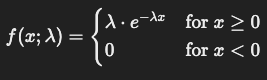

<h2> (Optional) : Simple agent based model of resource acquisiton based on wait-times generated from the maximum-entropy distribution <h2>

In [61]:
# Define the agent
class ResourceAgent(Agent):
    """ An agent that waits for resources based on a fitted exponential distribution. """
    
    def __init__(self, unique_id, model, lambda_param):
        super().__init__(unique_id, model)
        self.lambda_param = lambda_param  # Lambda for the exponential distribution
        self.wait_time = 0  # Time the agent has waited for resources
        self.resources_acquired = 0  # Track resources acquired by this agent

    def step(self):
        """ The agent waits for resources, incrementing its wait time. """
        # Generate a random waiting time based on the exponential distribution
        waiting_time = np.random.exponential(1 / self.lambda_param)
        self.wait_time += waiting_time

        # Check if the agent can acquire a resource
        if self.wait_time >= self.model.resource_threshold:
            self.acquire_resource()
            self.wait_time = 0  # Reset wait time after acquiring a resource
        
        # Trade resources with another agent
        self.trade_resources()

    def acquire_resource(self):
        """ The agent acquires a resource from the model. """
        if self.model.resources > 0:
            self.model.resources -= 1  # Decrement available resources
            self.resources_acquired += 1  # Increment resources acquired by this agent
            print(f"Agent {self.unique_id} acquired a resource!")

    def trade_resources(self):
        """ The agent trades resources with another agent. """
        # Choose a random agent to trade with
        other_agent = self.random.choice(self.model.schedule.agents)
        
        # Define trading logic: Prevent trading away all resources
        if self.resources_acquired > 1 and other_agent.resources_acquired > 0:
            # Both agents can trade one resource
            self.resources_acquired -= 1  # Give away a resource
            other_agent.resources_acquired += 1  # Receive a resource
            print(f"Agent {self.unique_id} traded 1 resource with Agent {other_agent.unique_id}!")

# Define the model
class ResourceManagementModel(Model):
    """A model with some number of agents."""
    
    def __init__(self, N, lambda_param):
        self.num_agents = N
        self.resources = 500  # Initial number of resources available
        self.resource_threshold = 2  # Threshold for resource acquisition
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = ResourceAgent(i, self, lambda_param)
            self.schedule.add(a)

    def step(self):
        """ Advance the model by one step. """
        self.schedule.step()

# Create the model
model = ResourceManagementModel(N=10, lambda_param=optimized_lambda)

# Run the model for a specified number of steps
for i in range(200):
    print(f"Step {i + 1}")
    model.step()

Step 1
Step 2
Agent 4 acquired a resource!
Step 3
Agent 0 acquired a resource!
Step 4
Agent 6 acquired a resource!
Agent 2 acquired a resource!
Step 5
Agent 1 acquired a resource!
Agent 3 acquired a resource!
Step 6
Agent 2 acquired a resource!
Agent 2 traded 1 resource with Agent 6!
Agent 5 acquired a resource!
Step 7
Agent 6 traded 1 resource with Agent 3!
Step 8
Agent 8 acquired a resource!
Agent 6 acquired a resource!
Agent 6 traded 1 resource with Agent 3!
Agent 7 acquired a resource!
Agent 3 traded 1 resource with Agent 0!
Agent 9 acquired a resource!
Step 9
Agent 4 acquired a resource!
Agent 4 traded 1 resource with Agent 3!
Agent 3 traded 1 resource with Agent 0!
Agent 0 traded 1 resource with Agent 0!
Agent 5 acquired a resource!
Agent 5 traded 1 resource with Agent 4!
Step 10
Agent 3 acquired a resource!
Agent 3 traded 1 resource with Agent 6!
Agent 6 traded 1 resource with Agent 5!
Agent 0 traded 1 resource with Agent 8!
Agent 4 traded 1 resource with Agent 5!
Step 11
Agent 

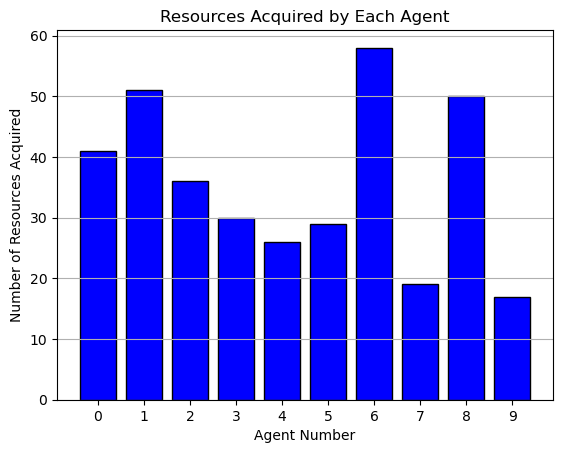

In [62]:
# Collect the number of resources acquired by each agent
resources_acquired = [agent.resources_acquired for agent in model.schedule.agents]

# Create bins for agents (0 to N-1)
agents = list(range(model.num_agents))

# Plotting the histogram of resources acquired by each agent
plt.bar(agents, resources_acquired, color='blue', edgecolor='black')
plt.xticks(agents)  # Set x-ticks to agent numbers
plt.xlabel('Agent Number')
plt.ylabel('Number of Resources Acquired')
plt.title('Resources Acquired by Each Agent')
plt.grid(axis='y')
plt.show()